In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

import math
import copy
import gc
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import preprocessing
import yake
from collections import defaultdict


from datasets import Dataset as DatasetHG
from datasets import DatasetDict
from tqdm import tqdm
from transformers import AutoTokenizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from IPython.display import display, clear_output
import random
import os

# Set seed constant value
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True # Only deterministic algorithms for getting same result
        torch.backends.cudnn.benchmark = False # Disables cuDNN's auto-tuning !!!!!!!!!!!!!!!!!!!!!
    worker_seed = seed % (2**32)
    torch.utils.data.DataLoader.worker_init_fn = lambda worker_id: np.random.seed(worker_seed + worker_id)

seed_everything(42)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, use_bias, use_lookahead_mask=False):
        super().__init__()
        # d_model: Dimensionality of the input.
        # num_heads: The number of attention heads to split the input into.

        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.use_bias = use_bias
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        self.use_lookahead_mask = use_lookahead_mask

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model,bias=self.use_bias) # Query transformation
        self.W_k = nn.Linear(d_model, d_model,bias=self.use_bias) # Key transformation
        self.W_v = nn.Linear(d_model, d_model,bias=self.use_bias) # Value transformation
        self.W_o = nn.Linear(d_model, d_model,bias=self.use_bias) # Output transformation

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        batch_size, seq_len_q, _ = Q.size()
        _, seq_len_k, _ = K.size()
        # Shapes are (batch_size, seq_len, d_model)
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) # .transpose(1,2) used due to the shape was (batch_size, seq_len, num_heads, d_k)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) # To make it (batch_size, num_heads, seq_len, d_k), because we are giving batches to heads
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Calculate attention scores
        # K.Transpose comes from the equation of attention score, which is Q.K^T.
        # So (batch_size, num_heads, seq_len_q, d_k) * (batch_size, num_heads, d_k, seq_len_k) = (batch_size, num_heads, seq_len_q, seq_len)
        attn_scores = torch.matmul(Q, K.transpose(2, 3)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))

        # Lookahead mask (used in Decoder)
        if self.use_lookahead_mask:
            subsequent_mask = torch.tril(torch.ones(seq_len_q, seq_len_k)).to(Q.device)
            attn_scores.masked_fill_(subsequent_mask == 0, 1e-10)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            __pad_mask = mask.unsqueeze(1).unsqueeze(3)
            # __pad_mask.shape: (batch_size, 1, seq_len_q, 1)
            # pad mask is broadcasted from q dimension
            # enc/dec case: q is the dimension of decoder output, k and v are from encoder
            # NOTE: using float('-inf') here can cause numerical instability!
            attn_scores.masked_fill_(__pad_mask == 0, 1e-10)

        # Softmax is applied to obtain attention probabilities
        self.attn_probs = torch.softmax(attn_scores, dim=-1)

        # Store attention probabilities in the dictionary
        # self.attn_probs_dict['attn_probs'] = self.attn_probs

        # Multiply by values to obtain the final output
        attn_output = torch.matmul(self.attn_probs, V)


        # Combine heads and apply output transformation sized as
        # (batch_size, seq_len_q, num_heads, head_dim) -> (batch_size, seq_len_q, features_dim)

        combined_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(combined_output)
        return output


In [ ]:
class AttentionResidualConnection(nn.Module):

    def __init__(self,layer,features_dim,dropout_prob,res_type='pre'):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(features_dim)
        self.dropout = nn.Dropout(dropout_prob)
        if not(res_type.lower() in ['pre','post','dual']):
            raise("Enter type as pre post or dual")
        else:
            self.res_type = res_type

    def forward(self,q,k,v,mask):
        if self.res_type.lower() == 'pre':
            return q + self.dropout(self.layer(self.norm(q), self.norm(k), self.norm(v), mask))
        elif self.res_type.lower() == 'post':
            return self.norm(q + self.dropout(self.layer(q,k,v,mask)))


In [ ]:
class FeedForward(nn.Module):
    def __init__(self,d_model,d_ff, ff_use_bias):
        super().__init__()
        self.pwff = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=ff_use_bias),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=ff_use_bias),
            )

    def forward(self,x):
        return self.pwff(x)

In [5]:
class FeedForwardResidualConnection(nn.Module):
    def __init__(self, layer, features_dim, dropout_prob, res_type='pre'):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(features_dim)
        self.dropout = nn.Dropout(dropout_prob)
        if not(res_type.lower() in ['pre','post','dual']):
            raise("Enter type as pre post or dual")
        else:
            self.res_type = res_type

    def forward(self, x):
        if self.res_type.lower() == 'pre':
            return x + self.dropout(self.layer(self.norm(x)))
        elif self.res_type.lower() == 'post':
            return self.norm(x + self.dropout(self.layer(x)))

#### Encoder - Decoder & MaskedOnlyDecoder Layers

- `AttentionResidualConnection`and `FeedForwardResidualConnection` are created to improve gradient flow.
- `use_lookahead_mask=True` part is to apply masking operation for Decoding Phase

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(
        self,
        features_dim,
        num_heads,
        ff_dim,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res
    ):
        super().__init__()

        self.mha = AttentionResidualConnection(
            layer=MultiHeadAttention(features_dim, num_heads, attn_use_bias),
            features_dim=features_dim,
            dropout_prob=attn_dropout_prob,
            res_type=attn_res,
        )

        self.ff = FeedForwardResidualConnection(
            layer=FeedForward(features_dim, ff_dim, ff_use_bias),
            features_dim=features_dim,
            dropout_prob=ff_dropout_prob,
            res_type=ff_res,
        )

    def forward(self, x_input, pad_mask):
        mha_out = self.mha(x_input, x_input, x_input, pad_mask)
        ff_out = self.ff(mha_out)
        return ff_out

class MaskedOnlyDecoderLayer(nn.Module):
    def __init__(
        self,
        features_dim,
        num_heads,
        ff_dim,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res
    ):
        super().__init__()

        self.m_mha = AttentionResidualConnection(
            layer=MultiHeadAttention(features_dim, num_heads, attn_use_bias, use_lookahead_mask=True),
            features_dim=features_dim,
            dropout_prob=attn_dropout_prob,
            res_type=attn_res,
        )

        self.ff = FeedForwardResidualConnection(
            layer=FeedForward(features_dim, ff_dim, ff_use_bias),
            features_dim=features_dim,
            dropout_prob=ff_dropout_prob,
            res_type=ff_res,
        )

    def forward(self, x_input, pad_mask):
        mha_out = self.m_mha(x_input, x_input, x_input, pad_mask)
        ff_out = self.ff(mha_out)
        return ff_out


class DecoderLayer(nn.Module):
    def __init__(
        self,
        features_dim,
        num_heads,
        ff_dim,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res
    ):
        super().__init__()

        # Masked Layer
        self.m_mha = AttentionResidualConnection(
            layer=MultiHeadAttention(features_dim, num_heads, attn_use_bias, use_lookahead_mask=True),
            features_dim=features_dim,
            dropout_prob=attn_dropout_prob,
            res_type=attn_res,
        )
        # Normal Attention Layer
        self.mha = AttentionResidualConnection(
            layer=MultiHeadAttention(features_dim, num_heads, attn_use_bias, use_lookahead_mask=False),
            features_dim=features_dim,
            dropout_prob=attn_dropout_prob,
            res_type=attn_res,
        )
        self.ff = FeedForwardResidualConnection(
            layer=FeedForward(features_dim, ff_dim, ff_use_bias),
            features_dim=features_dim,
            dropout_prob=ff_dropout_prob,
            res_type=ff_res,
        )

    def forward(self, x_input, x_cross, pad_mask,cross_pad_mask):
        mha_out = self.mha(x_input, x_input, x_input, pad_mask)
        masked_mha_out = self.mha(x_cross, mha_out, mha_out, cross_pad_mask) # q = Cross , k,v = x_input from mha
        ff_out = self.ff(masked_mha_out)
        return ff_out

#### Model Architecture 

Previous cells are for writing the classes that will be used on main architecture.

The models are:

- BERT: Uses only Encoder Layer and `x_input`.
- MaskedOnlyDecoder: Uses only MaskedOnlyDecoder Layer and `x_input`.
- GPT: Uses Decoder Layer that feeded via MaskedOnlyDecoder and `x_cross`Cross-Attention variable.
- T5: The main transformer layer. Uses BERT and GPT architecture.

In [ ]:
class BERT(nn.Module):
    def __init__(
        self,
        vocab_size,
        target_size,
        features_dim,
        num_heads,
        ff_dim,
        num_encoder_layers,
        emb_dropout_prob,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res,
        vocab_projection_bias,
    ):
        super().__init__()
        self.features_dim = features_dim

        self.token_emb = nn.Embedding(vocab_size, features_dim)

        # Learnable position embbedings
        #self.position_emb = nn.Embedding(max_seq_len, features_dim)

        self.emb_dropout_prob = nn.Dropout(p=emb_dropout_prob)

        # NOTE: nn.Sequential can't handle multiple inputs!
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(
                features_dim,
                num_heads,
                ff_dim,
                attn_dropout_prob,
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias,
                attn_res,
                ff_res,
            ) for _ in range(num_encoder_layers)]
        )
        self.layernorm_final = nn.LayerNorm(features_dim)

        self.vocab_projection = nn.Linear(features_dim, target_size, bias=vocab_projection_bias)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate_positional_embbedings(self, seq_len):

        pe = torch.zeros(seq_len, self.features_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, self.features_dim, 2) * -(math.log(10000.0) / self.features_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x_input, pad_mask=None):
        _batch_size, _seq_len = x_input.size()
        _token_emb = self.token_emb(x_input)
        _position_emb = self.generate_positional_embbedings(_seq_len).to(x_input.device)
        x_input = self.emb_dropout_prob(_token_emb + _position_emb)

        # Self attenting MHA
        for _enc_layer in self.enc_layers:
            x_input = _enc_layer(x_input, pad_mask)

        x_input = self.layernorm_final(x_input)
        x_input = self.vocab_projection(x_input)

        # shape [batch_size, seq_q_len, class_size] --> [batch_size, class_size]
        x_input = x_input.mean(dim=1)

        return x_input

In [ ]:
class MaskedDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        target_size,
        features_dim,
        num_heads,
        ff_dim,
        num_encoder_layers,
        emb_dropout_prob,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res,
        vocab_projection_bias,
    ):
        super().__init__()
        self.features_dim = features_dim

        self.token_emb = nn.Embedding(vocab_size, features_dim)

        # Learnable position embbedings
        #self.position_emb = nn.Embedding(max_seq_len, features_dim)

        self.emb_dropout_prob = nn.Dropout(p=emb_dropout_prob)

        # NOTE: nn.Sequential can't handle multiple inputs!
        self.mdec_layers = nn.ModuleList(
            [MaskedOnlyDecoderLayer(
                features_dim,
                num_heads,
                ff_dim,
                attn_dropout_prob,
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias,
                attn_res,
                ff_res,
            ) for _ in range(num_encoder_layers)]
        )
        self.layernorm_final = nn.LayerNorm(features_dim)

        self.vocab_projection = nn.Linear(features_dim, target_size, bias=vocab_projection_bias)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate_positional_embbedings(self, seq_len):

        pe = torch.zeros(seq_len, self.features_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, self.features_dim, 2) * -(math.log(10000.0) / self.features_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x_input, pad_mask=None):
        _batch_size, _seq_len = x_input.size()
        _token_emb = self.token_emb(x_input)
        _position_emb = self.generate_positional_embbedings(_seq_len).to(x_input.device)
        x_input = self.emb_dropout_prob(_token_emb + _position_emb)

        # Self attenting MHA
        for _mdec_layer in self.mdec_layers:
            x_input = _mdec_layer(x_input, pad_mask)

        x_input = self.layernorm_final(x_input)
        x_input = self.vocab_projection(x_input)

        # shape [batch_size, seq_q_len, class_size] --> [batch_size, class_size]
        x_input = x_input.mean(dim=1)

        return x_input

In [ ]:
class GPT(nn.Module):
    def __init__(
        self,
        vocab_size,
        target_size,
        features_dim,
        num_heads,
        ff_dim,
        num_encoder_layers,
        emb_dropout_prob,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res,
        vocab_projection_bias,
    ):
        super().__init__()
        self.features_dim = features_dim

        self.token_emb = nn.Embedding(vocab_size, features_dim)
        self.c_token_emb = nn.Embedding(vocab_size, features_dim)

        # Learnable position embbedings
        #self.position_emb = nn.Embedding(max_seq_len, features_dim)

        self.emb_dropout_prob = nn.Dropout(p=emb_dropout_prob)

        # NOTE: nn.Sequential can't handle multiple inputs!
        self.dec_layers = nn.ModuleList(
            [DecoderLayer(
                features_dim,
                num_heads,
                ff_dim,
                attn_dropout_prob,
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias,
                attn_res,
                ff_res,
            ) for _ in range(num_encoder_layers)]
        )
        self.layernorm_final = nn.LayerNorm(features_dim)

        self.vocab_projection = nn.Linear(features_dim, target_size, bias=vocab_projection_bias)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate_positional_embbedings(self, seq_len):

        pe = torch.zeros(seq_len, self.features_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, self.features_dim, 2) * -(math.log(10000.0) / self.features_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x_input, x_cross, pad_mask=None, cross_pad_mask=None):
        _batch_size, _seq_len = x_input.size()
        _token_emb = self.token_emb(x_input)
        _position_emb = self.generate_positional_embbedings(_seq_len).to(x_input.device)
        x_input = self.emb_dropout_prob(_token_emb + _position_emb)

        # Cross Emb
        c_batch_size, c_seq_len = x_cross.size()
        c_token_emb = self.c_token_emb(x_cross)
        c_position_emb = self.generate_positional_embbedings(c_seq_len).to(x_cross.device)
        x_cross = self.emb_dropout_prob(c_token_emb + c_position_emb)

        # Self attenting MHA
        for _dec_layer in self.dec_layers:
            x_cross = _dec_layer(x_input, x_cross, pad_mask, cross_pad_mask)

        x_cross = self.layernorm_final(x_cross)
        x_cross = self.vocab_projection(x_cross)

        # shape [batch_size, seq_q_len, class_size] --> [batch_size, class_size]
        x_cross = x_cross.mean(dim=1)

        return x_cross

In [ ]:
class T5(nn.Module):
    def __init__(
        self,
        vocab_size,
        target_size,
        features_dim,
        num_heads,
        ff_dim,
        num_encoder_layers,
        emb_dropout_prob,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        attn_res,
        ff_res,
        vocab_projection_bias,
    ):
        super().__init__()
        self.features_dim = features_dim

        self.token_emb = nn.Embedding(vocab_size, features_dim)
        self.c_token_emb = nn.Embedding(vocab_size, features_dim)

        # Learnable position embbedings
        #self.position_emb = nn.Embedding(max_seq_len, features_dim)

        self.emb_dropout_prob = nn.Dropout(p=emb_dropout_prob)

        # NOTE: nn.Sequential can't handle multiple inputs!

        # NOTE: nn.Sequential can't handle multiple inputs!
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(
                features_dim,
                num_heads,
                ff_dim,
                attn_dropout_prob,
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias,
                attn_res,
                ff_res,
            ) for _ in range(num_encoder_layers)]
        )

        self.dec_layers = nn.ModuleList(
            [DecoderLayer(
                features_dim,
                num_heads,
                ff_dim,
                attn_dropout_prob,
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias,
                attn_res,
                ff_res,
            ) for _ in range(num_encoder_layers)]
        )
        self.layernorm_final = nn.LayerNorm(features_dim)

        self.vocab_projection = nn.Linear(features_dim, target_size, bias=vocab_projection_bias)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate_positional_embbedings(self, seq_len):

        pe = torch.zeros(seq_len, self.features_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, self.features_dim, 2) * -(math.log(10000.0) / self.features_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x_input, x_cross, pad_mask=None, cross_pad_mask=None):
        _batch_size, _seq_len = x_input.size()
        _token_emb = self.token_emb(x_input)
        _position_emb = self.generate_positional_embbedings(_seq_len).to(x_input.device)
        x_input = self.emb_dropout_prob(_token_emb + _position_emb)

        # Cross Emb
        c_batch_size, c_seq_len = x_cross.size()
        c_token_emb = self.c_token_emb(x_cross)
        c_position_emb = self.generate_positional_embbedings(c_seq_len).to(x_cross.device)
        x_cross = self.emb_dropout_prob(c_token_emb + c_position_emb)


        # Self attenting MHA
        for _enc_layer in self.enc_layers:
            x_input = _enc_layer(x_input, pad_mask)

        # Cross attenting MHA
        for _dec_layer in self.dec_layers:
            x_cross = _dec_layer(x_input, x_cross, pad_mask, cross_pad_mask)

        x_cross = self.layernorm_final(x_cross)
        x_cross = self.vocab_projection(x_cross)

        # shape [batch_size, seq_q_len, class_size] --> [batch_size, class_size]
        x_cross = x_cross.mean(dim=1)

        return x_cross

## Prepare Custom Dataset
#### Convert data to DatasetDict

<small>Only train dataset is used for whole training instead of splitted version. I had 25k variable and was enough for this dummy training.</small>

<small> And yes. Me and myself decided in that way :D </small>

<small>You can use both ofcourse.</small>

In [2]:
df = pd.read_csv('train.csv', encoding='unicode_escape')
df = df[['selected_text','sentiment']]
df = df.dropna()
labels = df['sentiment'].unique().tolist()
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splitter.get_n_splits(df['selected_text'],df['sentiment'])

for train_index, test_index in splitter.split(df['selected_text'], df['sentiment']):
    train_dataset = DatasetHG.from_pandas(df.iloc[train_index])
    train_dataset = train_dataset.remove_columns(['__index_level_0__'])
    test_dataset = DatasetHG.from_pandas(df.iloc[test_index])
    test_dataset = test_dataset.remove_columns(['__index_level_0__'])
    my_dataset_dict = DatasetDict({"train":train_dataset,"test":test_dataset})
my_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['selected_text', 'sentiment'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['selected_text', 'sentiment'],
        num_rows: 5496
    })
})

In [3]:
max_seq = 0
for i in ['train','test']:
    for j in my_dataset_dict[i][:]['selected_text']:
        str_len = len(str(j).split())
        if str_len > max_seq:
            max_seq = str_len
max_seq

33

#### Find max sequence lenght

In [ ]:
source_lang = "selected_text"
target_lang = "sentiment"
label_encoder = preprocessing.LabelEncoder()

def preprocess_function(examples,max_seq):
    inputs = []
    for example in examples[source_lang]:
        inputs.append(str(example))
    target = label_encoder.fit_transform(examples[target_lang])
    targets = [int(example) for example in target]
    # max size of sentence or avg
    model_inputs = tokenizer(inputs, padding="max_length", max_length=max_seq, truncation=True, return_tensors='pt')
    model_inputs['labels'] = torch.tensor(targets, dtype=torch.int8)
    return model_inputs


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenized_datasets = my_dataset_dict.map(lambda : examples, preprocess_function(examples,max_seq=max_seq), batched=True)

c:\Users\batuhan.yildirim\AppData\Local\anaconda3\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

#### Clustering For Cross Attention

- For cross atteion, a theme, a sencence is needed. According to Elbow method, 13 clusters is feasable.

In [ ]:
K = 13

X = tokenized_datasets['train'][:]['input_ids'] + tokenized_datasets['test'][:]['input_ids']
X_text = tokenized_datasets['train'][:]['selected_text'] + tokenized_datasets['test'][:]['selected_text']

clustering = KMeans(n_clusters=K, random_state=42).fit(X)

cluster_texts = defaultdict(list)
for label, text in zip(clustering.labels_, X_text):
    cluster_texts[label].append(text)

used_keywords = set()
kw_extractor = yake.KeywordExtractor(lan='en', n=4,  top=20, features=None)
cluster_keywords = {}
for cluster, texts in cluster_texts.items():
    combined_text = ' '.join(str(t) for t in texts)

    keywords = [kw[0].lower() for kw in kw_extractor.extract_keywords(combined_text)]

    for keyword in keywords:
        if keyword not in used_keywords:
            cluster_keywords[cluster] = keyword
            used_keywords.add(keyword)
            break
        else:
            cluster_keywords[cluster] = f"Cluster_{cluster}"

cluster_keywords = dict(sorted(cluster_keywords.items()))
print(cluster_keywords)

# Assing Labels to Dataset
def assign_cluster_labels(examples, labels):
    token_res = tokenizer(cluster_keywords[labels], padding="max_length", max_length=33, truncation=True, return_tensors='pt')
    return {'cluster_labels': cluster_keywords[labels],
            'cluster_ids': token_res['input_ids'].squeeze(0),
            'cluster_mask': token_res['attention_mask'].squeeze(0)}


train_size = len(tokenized_datasets['train'])
train_labels = clustering.labels_[:train_size]
test_labels = clustering.labels_[train_size:]

tokenized_datasets['train'] = tokenized_datasets['train'].map(
    lambda examples, idx: assign_cluster_labels(examples, train_labels[idx]),
    with_indices=True
)
tokenized_datasets['test'] = tokenized_datasets['test'].map(
    lambda examples, idx: assign_cluster_labels(examples, test_labels[idx]),
    with_indices=True)

{0: 'amazing is so glad', 1: 'day', 2: 'love me some home', 3: 'bed hows ur day', 4: 'soooo sorry we love', 5: 'ready for a good', 6: 'happy with my day', 7: 'good to be back', 8: 'time of the morning', 9: 'day to your mom', 10: 'days with my friends', 11: 'day so far hope', 12: 'ready for dc tomorrow'}


Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

In [5]:
tokenizer.vocab_size

30522

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['selected_text', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cluster_labels', 'cluster_ids', 'cluster_mask'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['selected_text', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cluster_labels', 'cluster_ids', 'cluster_mask'],
        num_rows: 5496
    })
})

### Training and Evaluating Model

In [ ]:
# model, emb, layer, batch
params = [
            ['BERT',128,2,2048], # Tiny
            ['BERT',256,4,1024], # Mini
            ['BERT',512,4,512],  # Small
            ['BERT',512,8,256],  # Medium
            # ['BERT',768,12,32],  # Base
            # ['BERT',1024,24,32],  # Large
            ['MaskedDecoder',128,2,2048], # Tiny
            ['MaskedDecoder',256,4,1024], # Mini
            ['MaskedDecoder',512,4,512],  # Small
            ['MaskedDecoder',512,8,256],  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            ['GPT',128,2,2048], # Tiny
            ['GPT',256,4,1024], # Mini
            ['GPT',512,4,512],  # Small
            ['GPT',512,8,256],  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            ['T5',128,2,2048], # Tiny
            ['T5',256,4,1024], # Mini
            ['T5',512,4,256],  # Small
            ['T5',512,8,128],  # Medium
            # ['T5',768,12,8],  # Base
            # ['T5',1024,24,32],  # Large
        ]
# Plot Learning rate curve, epoch loss,

### Training process

##### Custom Learning Rate Scheduler from

In training process, due to model starts to learn in nth epoch, learning rate must be reduced when thraining is continued. The method which suggested in `Attention is all you need` paper are created on the links below.

_ScheduledOptim_
- https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/132907dd272e2cc92e3c10e6c4e783a87ff8893d/transformer/Optim.py#L4

_NoamOpt_
- https://nlp.seas.harvard.edu/2018/04/03/attention.html#hardware-and-schedule

I used Noam Optimizaton in this case and didn't complete the ScheduledOptim.


In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

# Example Using
# ScheduledOptim(optimizer, d_model=d_model, n_warmup_steps=n_warmup_steps)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
#get_sch_pot(model,optimizer)


class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self.optimizer.zero_grad()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def state_dict(self):
        return self.optimizer.state_dict()

# NoamOpt(d_model, 2, 4000,optimizer)

#### Basic Version ( Newer one at under)

The basic training. Get input and target, predict result from model which is output, get the loss via output and target, evaluate and repeat the loop.

The improve version tries to optimize the training process.

In [ ]:
vocab_size = tokenizer.vocab_size
target_size = 3
num_heads = 8

dropout = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 150

general_loss = []
general_lr = []
general_gpu_usage = []

for param in params:
    d_model = param[1]
    d_ff = d_model* 4
    num_layers = param[2]
    batch_size = param[3]

    if param[0] == 'GPT':
        model = GPT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'BERT':
        model = BERT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)
    else:
        print('Error ')
        break


    train_loader = DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True)
    #val_loader = DataLoader(tokenized_datasets['validation'], batch_size=d_model)
    test_loader = DataLoader(tokenized_datasets['test'], batch_size=batch_size, shuffle=True)

    class_weights = torch.tensor([1.2, 1.0, 1.0])

    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    # scheduler = ScheduledOptim(optimizer, d_model=d_model, n_warmup_steps=4000)

    print('Params are : ', param)
    def train_model(model, train_dataloader, criterion, optimizer, grad_acc=False, accum_iter = 4):
        model.train()
        epoch_loss = 0
        for batch_idx, batch in enumerate(tqdm(train_dataloader)):

            src = torch.stack(batch["input_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
            trg = batch["labels"].to(device) # shape --> [1, batch size] (batbt, )
            pad_mask = torch.stack(batch["attention_mask"]).transpose(0,1).to(device)
            # print('src: ',src.shape,'trg: ', trg.shape)
            # shape (out) --> [batch size, trg size]

            if grad_acc == True: # To apply Gradient Accumulation
                # passes and weights update
                with torch.set_grad_enabled(True):
                    # forward pass
                    out = model(src, pad_mask)
                    loss = criterion(out, trg)

                    # normalize loss to account for batch accumulation
                    loss = loss / accum_iter

                    # backward pass
                    loss.backward()

                    # Grading Clipping for Higher Values and fixing None error
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2.0, error_if_nonfinite=False, foreach=None)

                    # weights update
                    if (((batch_idx + 1) % accum_iter) == 0) or (batch_idx + 1 == len(train_dataloader)):
                        optimizer.step()
                        optimizer.zero_grad()

                    epoch_loss += loss.detach().cpu()

            else:
                out = model(src, pad_mask)
                #print('out: ',out.shape)
                loss = criterion(out, trg)
                #print(out, trg)

                loss.backward()

                optimizer.step()
                # Clear the accumulating gradients
                optimizer.zero_grad()
                epoch_loss += loss.detach().cpu()

        return epoch_loss/len(train_dataloader)


    def evaluate_model(model, valid_dataloader, criterion):
        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_dataloader):

                src = torch.stack(batch["input_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
                trg = batch["labels"].to(device) # shape --> [batch size]
                pad_mask = torch.stack(batch["attention_mask"]).transpose(0,1).to(device)
                #print('src: ',src.shape,'trg: ', trg.shape)
                # shape (out) --> [batch size, trg size]
                out = model(src, pad_mask)
                loss = criterion(out, trg)

                epoch_loss += loss.detach().cpu()

        return epoch_loss/len(valid_dataloader)

    patience = 100
    best_model = {}
    best_epoch = 0
    best_loss = 100

    epoch_loss = 0

    eval_loss_list = []
    lr_list = []
    all_gpu_usage = []
    for epoch in range(num_epochs):

        start = time.time()
        gc.collect() # Garbage collector
        torch.cuda.empty_cache()

        epoch_loss = train_model(model, train_loader, criterion, optimizer,grad_acc=True)
        eval_loss = evaluate_model(model, test_loader, criterion)
        scheduler.step()

        gpu_usage = (torch.cuda.mem_get_info()[1] - torch.cuda.mem_get_info()[0])/(1073741824.0)
        total_gpu = torch.cuda.mem_get_info()[1]/1073741824.0

        # For plotting
        eval_loss_list.append(float(eval_loss))
        lr_list.append(float(optimizer.param_groups[0]['lr']))
        all_gpu_usage.append(float(gpu_usage))

        # Add F1-Score Accuracy metric for loss
        print(f" Epoch: {epoch+1}, Train loss: {epoch_loss:.5f}, Eval loss: {eval_loss:.5f}, LR: {optimizer.param_groups[0]['lr']}. Time {time.time() - start:.2f} secs. Total GPU Memory { gpu_usage :.2f}/{total_gpu :.2f}GB")
        # Early stopping
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = 100  # Reset patience counter
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'eval_loss': best_loss,
                'epoch_num': epoch,
            }, f'{param[0]}-{param[1]}_embs-{param[2]}_layers-{param[3]}_batches-transformer.pt')
        else:
            patience -= 1
            # print("patience: ",patience)
            # if patience == 0:
            #     break
    general_loss.append(eval_loss_list)
    general_lr.append(lr_list)
    general_gpu_usage.append(sum(all_gpu_usage)/ len(all_gpu_usage))
    clear_output(wait=True)


##### Improved Version with
- Autocasting and GradScaler
- Custom Learning Rate Scheduler from `Attention is All You Need` paper
- Constant Seed for potential libraries 
- Grading Clipping

Two of the improvements were in the cells above. I discovered them after applying the basic one ofcourse.

I had some problems, which needed some solutions.

and here we are.

In [ ]:
# model, emb, layer, batch
params = [
            ['BERT',128,2,2048], # Tiny
            ['BERT',256,4,1024], # Mini
            ['BERT',512,4,512],  # Small
            ['BERT',512,8,256],  # Medium
            # ['BERT',768,12,32],  # Base
            # ['BERT',1024,24,32],  # Large
            ['MaskedDecoder',128,2,2048], # Tiny
            ['MaskedDecoder',256,4,1024], # Mini
            ['MaskedDecoder',512,4,512],  # Small
            ['MaskedDecoder',512,8,256],  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            ['GPT',128,2,2048], # Tiny
            ['GPT',256,4,1024], # Mini
            ['GPT',512,4,512],  # Small
            ['GPT',512,8,256],  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            ['T5',128,2,2048], # Tiny
            ['T5',256,4,1024], # Mini
            ['T5',512,4,256],  # Small
            ['T5',512,8,128],  # Medium
            # ['T5',768,12,8],  # Base
            # ['T5',1024,24,32],  # Large
        ]
# Plot Learning rate curve, epoch loss,

In [ ]:
vocab_size = tokenizer.vocab_size
target_size = 3
num_heads = 8

dropout = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 150

general_loss = []
general_lr = []
general_gpu_usage = []

for param in params:
    d_model = param[1]
    d_ff = d_model* 4
    num_layers = param[2]
    batch_size = param[3]

    if param[0] == 'GPT':
        model = GPT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'MaskedDecoder':
        model = MaskedDecoder(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'BERT':
        model = BERT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'T5':
        model = T5(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)
    else:
        print('Error ')
        break

    train_loader = DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True)
    #val_loader = DataLoader(tokenized_datasets['validation'], batch_size=d_model, shuffle=True)
    test_loader = DataLoader(tokenized_datasets['test'], batch_size=batch_size, shuffle=True)

    class_weights = torch.tensor([1.2, 1.0, 1.0])

    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    optimizer = NoamOpt(model_size=d_model,factor=0.1, warmup=25, optimizer=optim.Adam(model.parameters(), lr=0.001))
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    scaler = torch.amp.GradScaler(device=device)
    #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    print('Params are : ', param)
    def train_model(model, train_dataloader, criterion, optimizer, grad_acc=False, accum_iter = 4):
        model.train()
        epoch_loss = 0
        for batch_idx, batch in enumerate(tqdm(train_dataloader)):

            # Auto Casting
            with torch.autocast(device_type=device.type, dtype=torch.float16):

                src = torch.stack(batch["input_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
                trg = batch["labels"].to(device) # shape --> [1, batch size] (batbt, )
                pad_mask = torch.stack(batch["attention_mask"]).transpose(0,1).to(device)

                # print('src: ',src.shape,'trg: ', trg.shape)
                # shape (out) --> [batch size, trg size]

                if grad_acc == True: # To apply Gradient Accumulation
                    # passes and weights update
                    with torch.set_grad_enabled(True):
                        # forward pass
                        if param[0] == 'T5' or param[0] == 'GPT':
                            cross_src = torch.stack(batch["cluster_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
                            cross_pad_mask = torch.stack(batch["cluster_mask"]).transpose(0,1).to(device)
                            out = model(src, cross_src, pad_mask, cross_pad_mask)
                        else:
                            out = model(src, pad_mask)

                        assert out.dtype is torch.float16

                        loss = criterion(out, trg)
                        assert loss.dtype is torch.float32
                        # normalize loss to account for batch accumulation
                        loss = loss / accum_iter

                        # Scales loss. Calls ``backward()`` on scaled loss to create scaled gradients.
                        scaler.scale(loss).backward()

                        # Grading Clipping for Higher Values and fixing None error
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2.0, error_if_nonfinite=False, foreach=None)

                        # weights update
                        if (((batch_idx + 1) % accum_iter) == 0) or (batch_idx + 1 == len(train_dataloader)):
                            optimizer.step()
                            optimizer.zero_grad()

                        epoch_loss += loss.detach().cpu()

                else:
                    # output is float16 because linear layers ``autocast`` to float16.
                    if param[0] == 'T5':
                        out = model(src, cross_src, pad_mask, cross_pad_mask)
                    else:
                        out = model(src, pad_mask)

                    assert out.dtype is torch.float16

                    loss = criterion(out, trg)
                    assert loss.dtype is torch.float32

                    # loss.backward()

                    # Scales loss. Calls ``backward()`` on scaled loss to create scaled gradients.
                    scaler.scale(loss).backward()

                    optimizer.step()
                    # Clear the accumulating gradients
                    optimizer.zero_grad()
                    epoch_loss += loss.detach().cpu()

        return epoch_loss/len(train_dataloader)


    def evaluate_model(model, valid_dataloader, criterion):
        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_dataloader):
                # Auto Casting
                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    src = torch.stack(batch["input_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
                    trg = batch["labels"].to(device) # shape --> [batch size]
                    pad_mask = torch.stack(batch["attention_mask"]).transpose(0,1).to(device)
                    #print('src: ',src.shape,'trg: ', trg.shape)
                    # shape (out) --> [batch size, trg size]
                    if param[0] == 'T5' or param[0] == 'GPT':
                        cross_src = torch.stack(batch["cluster_ids"]).transpose(0,1).to(device) # shape --> [batch size,seq len]
                        cross_pad_mask = torch.stack(batch["cluster_mask"]).transpose(0,1).to(device)
                        out = model(src, cross_src, pad_mask, cross_pad_mask)
                    else:
                        out = model(src, pad_mask)

                    loss = criterion(out, trg)

                    epoch_loss += loss.detach().cpu()

        return epoch_loss/len(valid_dataloader)


    patience = 100 # Patience for early stopping
    best_model = {}
    best_epoch = 0
    best_loss = 100 # Given randomly

    epoch_loss = 0

    eval_loss_list = []
    lr_list = []
    all_gpu_usage =[]
    for epoch in range(num_epochs):

        start = time.time()
        gc.collect() # Garbage collector
        torch.cuda.empty_cache()

        epoch_loss = train_model(model, train_loader, criterion, optimizer,grad_acc=True)
        eval_loss = evaluate_model(model, test_loader, criterion)
        #scheduler.step()
        gpu_usage = (torch.cuda.mem_get_info()[1] - torch.cuda.mem_get_info()[0])/(1073741824.0)
        total_gpu = torch.cuda.mem_get_info()[1]/1073741824.0

        # For plotting
        eval_loss_list.append(float(eval_loss))
        #lr_list.append(float(optimizer.param_groups[0]['lr']))
        lr_rate = float(optimizer.get_lr())
        lr_list.append(float(lr_rate))
        all_gpu_usage.append(gpu_usage)




        print(f" Epoch: {epoch+1}, Train loss: {epoch_loss:.5f}, Eval loss: {eval_loss:.5f}, LR: {lr_rate}. Time {time.time() - start:.2f} secs. Total GPU Memory {gpu_usage :.2f}/{total_gpu :.2f}GB Best: {eval_loss < best_loss}")
        # Early stopping
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = 100  # Reset patience counter
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'eval_loss': best_loss,
                'epoch_num': epoch,
            }, f'{param[0]}-{param[1]}_embs-{param[2]}_layers-{param[3]}_batches-transformer.pt')
        else:
            patience -= 1
            # print("patience: ",patience)
            # if patience == 0:
            #     break

    general_loss.append(eval_loss_list)
    general_lr.append(lr_list)
    general_gpu_usage.append(sum(all_gpu_usage)/ len(all_gpu_usage))
    clear_output(wait=True)


Params are :  ['GPT', 512, 8, 256]


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 1, Train loss: 0.32225, Eval loss: 1.05269, LR: 0.0007778174593052024. Time 22.14 secs. Total GPU Memory 4.88/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 2, Train loss: 0.23459, Eval loss: 0.85493, LR: 0.0006662522386112826. Time 22.04 secs. Total GPU Memory 5.08/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 3, Train loss: 0.21814, Eval loss: 0.86430, LR: 0.0005439926748615558. Time 22.02 secs. Total GPU Memory 5.06/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 4, Train loss: 0.21677, Eval loss: 0.88167, LR: 0.0004711114759027557. Time 22.14 secs. Total GPU Memory 5.04/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 5, Train loss: 0.22173, Eval loss: 0.83902, LR: 0.0004213749140395263. Time 22.11 secs. Total GPU Memory 5.04/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 6, Train loss: 0.21360, Eval loss: 0.82179, LR: 0.0003846609093104149. Time 22.12 secs. Total GPU Memory 5.07/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 7, Train loss: 0.20374, Eval loss: 0.75097, LR: 0.00035612680143636867. Time 22.06 secs. Total GPU Memory 5.03/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 8, Train loss: 0.19406, Eval loss: 0.75456, LR: 0.0003331261193056413. Time 22.04 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 9, Train loss: 0.19132, Eval loss: 0.72257, LR: 0.0003140743172685038. Time 22.18 secs. Total GPU Memory 5.09/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 10, Train loss: 0.18087, Eval loss: 0.72967, LR: 0.00029795705913924765. Time 22.01 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 11, Train loss: 0.17845, Eval loss: 0.70093, LR: 0.00028409090909090913. Time 22.05 secs. Total GPU Memory 5.02/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 12, Train loss: 0.17067, Eval loss: 0.69763, LR: 0.0002719963374307779. Time 22.14 secs. Total GPU Memory 5.10/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 13, Train loss: 0.16733, Eval loss: 0.66512, LR: 0.0002613256281272159. Time 22.12 secs. Total GPU Memory 5.03/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 14, Train loss: 0.16190, Eval loss: 0.64721, LR: 0.00025181967625793135. Time 22.08 secs. Total GPU Memory 5.09/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 15, Train loss: 0.15522, Eval loss: 0.65089, LR: 0.00024328092005047592. Time 22.03 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 16, Train loss: 0.14993, Eval loss: 0.62250, LR: 0.00023555573795137785. Time 22.02 secs. Total GPU Memory 5.02/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 17, Train loss: 0.15197, Eval loss: 0.59971, LR: 0.00022852263253972835. Time 22.09 secs. Total GPU Memory 5.10/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 18, Train loss: 0.14366, Eval loss: 0.59415, LR: 0.00022208407953709425. Time 22.10 secs. Total GPU Memory 5.04/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 19, Train loss: 0.14032, Eval loss: 0.56274, LR: 0.00021616076995814834. Time 22.18 secs. Total GPU Memory 5.11/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 20, Train loss: 0.14262, Eval loss: 0.58605, LR: 0.00021068745701976316. Time 22.04 secs. Total GPU Memory 5.04/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 21, Train loss: 0.13545, Eval loss: 0.56923, LR: 0.00020560990467492781. Time 22.07 secs. Total GPU Memory 5.04/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 22, Train loss: 0.13025, Eval loss: 0.54521, LR: 0.00020088260829163285. Time 22.10 secs. Total GPU Memory 5.04/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 23, Train loss: 0.12624, Eval loss: 0.54331, LR: 0.00019646706670685358. Time 22.10 secs. Total GPU Memory 5.10/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 24, Train loss: 0.12429, Eval loss: 0.53798, LR: 0.00019233045465520744. Time 22.06 secs. Total GPU Memory 5.03/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 25, Train loss: 0.11931, Eval loss: 0.52712, LR: 0.0001884445903611023. Time 22.20 secs. Total GPU Memory 5.12/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 26, Train loss: 0.12202, Eval loss: 0.52034, LR: 0.00018478512374658833. Time 22.09 secs. Total GPU Memory 5.04/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 27, Train loss: 0.11655, Eval loss: 0.50272, LR: 0.0001813308916205186. Time 22.05 secs. Total GPU Memory 5.10/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 28, Train loss: 0.11265, Eval loss: 0.52604, LR: 0.00017806340071818434. Time 22.00 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 29, Train loss: 0.11047, Eval loss: 0.53406, LR: 0.0001749664096737045. Time 21.99 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 30, Train loss: 0.11066, Eval loss: 0.50319, LR: 0.00017202558830099388. Time 22.12 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 31, Train loss: 0.10848, Eval loss: 0.52827, LR: 0.00016922823783558825. Time 22.06 secs. Total GPU Memory 5.04/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 32, Train loss: 0.10611, Eval loss: 0.48919, LR: 0.00016656305965282066. Time 22.00 secs. Total GPU Memory 5.03/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 33, Train loss: 0.10317, Eval loss: 0.50677, LR: 0.0001640199628379619. Time 22.10 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 34, Train loss: 0.10574, Eval loss: 0.48140, LR: 0.0001615899031234435. Time 22.05 secs. Total GPU Memory 5.11/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 35, Train loss: 0.10265, Eval loss: 0.51057, LR: 0.00015926474732425803. Time 22.10 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 36, Train loss: 0.10248, Eval loss: 0.48857, LR: 0.0001570371586342519. Time 22.01 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 37, Train loss: 0.09891, Eval loss: 0.47251, LR: 0.00015490049909269057. Time 22.04 secs. Total GPU Memory 5.03/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 38, Train loss: 0.09912, Eval loss: 0.48715, LR: 0.00015284874626391205. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 39, Train loss: 0.09724, Eval loss: 0.47852, LR: 0.00015087642174539613. Time 22.12 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 40, Train loss: 0.09431, Eval loss: 0.49330, LR: 0.00014897852956962383. Time 22.03 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 41, Train loss: 0.09386, Eval loss: 0.49709, LR: 0.0001471505029212535. Time 22.13 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 42, Train loss: 0.09478, Eval loss: 0.52614, LR: 0.00014538815787476107. Time 22.01 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 43, Train loss: 0.09129, Eval loss: 0.45953, LR: 0.00014368765308490718. Time 22.05 secs. Total GPU Memory 5.10/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 44, Train loss: 0.09050, Eval loss: 0.49243, LR: 0.00014204545454545457. Time 22.12 secs. Total GPU Memory 5.04/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 45, Train loss: 0.08897, Eval loss: 0.46080, LR: 0.0001404583046798421. Time 22.05 secs. Total GPU Memory 5.03/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 46, Train loss: 0.08757, Eval loss: 0.48322, LR: 0.00013892319514824595. Time 22.04 secs. Total GPU Memory 5.02/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 47, Train loss: 0.08564, Eval loss: 0.50251, LR: 0.00013743734285423206. Time 22.26 secs. Total GPU Memory 5.01/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 48, Train loss: 0.08699, Eval loss: 0.48051, LR: 0.00013599816871538896. Time 22.15 secs. Total GPU Memory 5.01/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 49, Train loss: 0.08555, Eval loss: 0.48221, LR: 0.00013460327882935878. Time 22.13 secs. Total GPU Memory 5.02/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 50, Train loss: 0.08457, Eval loss: 0.48001, LR: 0.00013325044772225653. Time 22.03 secs. Total GPU Memory 5.02/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 51, Train loss: 0.08247, Eval loss: 0.45736, LR: 0.00013193760341273408. Time 22.17 secs. Total GPU Memory 5.01/6.00GB Best: True


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 52, Train loss: 0.08272, Eval loss: 0.48959, LR: 0.00013066281406360795. Time 22.02 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 53, Train loss: 0.08266, Eval loss: 0.50178, LR: 0.0001294242760254035. Time 22.00 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 54, Train loss: 0.08065, Eval loss: 0.50252, LR: 0.00012822030310347162. Time 22.05 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 55, Train loss: 0.08238, Eval loss: 0.50170, LR: 0.00012704931690339714. Time 22.11 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 56, Train loss: 0.07964, Eval loss: 0.49213, LR: 0.00012590983812896567. Time 22.09 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.35it/s]


 Epoch: 57, Train loss: 0.07848, Eval loss: 0.50176, LR: 0.00012480047872357372. Time 22.20 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 58, Train loss: 0.07666, Eval loss: 0.48328, LR: 0.00012371993476013998. Time 22.15 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 59, Train loss: 0.07751, Eval loss: 0.50850, LR: 0.00012266697999669684. Time 22.14 secs. Total GPU Memory 5.11/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 60, Train loss: 0.07599, Eval loss: 0.49810, LR: 0.00012164046002523796. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 61, Train loss: 0.07463, Eval loss: 0.51528, LR: 0.00012063928695034111. Time 22.16 secs. Total GPU Memory 5.12/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 62, Train loss: 0.07491, Eval loss: 0.49370, LR: 0.00011966243454179433. Time 22.22 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 63, Train loss: 0.07452, Eval loss: 0.48986, LR: 0.00011870893381212287. Time 22.05 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 64, Train loss: 0.07386, Eval loss: 0.50565, LR: 0.00011777786897568893. Time 22.01 secs. Total GPU Memory 5.06/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 65, Train loss: 0.07316, Eval loss: 0.48570, LR: 0.00011686837375105716. Time 22.05 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 66, Train loss: 0.07254, Eval loss: 0.47895, LR: 0.00011597962797268837. Time 22.01 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 67, Train loss: 0.07157, Eval loss: 0.47563, LR: 0.0001151108544818371. Time 22.10 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 68, Train loss: 0.07121, Eval loss: 0.50669, LR: 0.00011426131626986418. Time 22.13 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 69, Train loss: 0.07014, Eval loss: 0.50374, LR: 0.00011343031385009811. Time 22.13 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 70, Train loss: 0.06891, Eval loss: 0.51822, LR: 0.00011261718283694488. Time 22.16 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 71, Train loss: 0.06863, Eval loss: 0.50350, LR: 0.0001118212917132052. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 72, Train loss: 0.06725, Eval loss: 0.51771, LR: 0.00011104203976854712. Time 22.15 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 73, Train loss: 0.06985, Eval loss: 0.52875, LR: 0.00011027885519384149. Time 22.24 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 74, Train loss: 0.06879, Eval loss: 0.48396, LR: 0.00010953119331762213. Time 22.03 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 75, Train loss: 0.06756, Eval loss: 0.55343, LR: 0.00010879853497231114. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 76, Train loss: 0.06716, Eval loss: 0.51992, LR: 0.00010808038497907417. Time 22.19 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 77, Train loss: 0.06585, Eval loss: 0.51464, LR: 0.00010737627074125777. Time 22.17 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 78, Train loss: 0.06500, Eval loss: 0.47374, LR: 0.0001066857409373311. Time 22.12 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 79, Train loss: 0.06499, Eval loss: 0.48049, LR: 0.00010600836430511851. Time 22.12 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 80, Train loss: 0.06315, Eval loss: 0.52373, LR: 0.00010534372850988158. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 81, Train loss: 0.06332, Eval loss: 0.50849, LR: 0.00010469143908950127. Time 22.11 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 82, Train loss: 0.06564, Eval loss: 0.49652, LR: 0.0001040511184706292. Time 22.11 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 83, Train loss: 0.06296, Eval loss: 0.50252, LR: 0.00010342240505023363. Time 22.13 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 84, Train loss: 0.06371, Eval loss: 0.51531, LR: 0.00010280495233746391. Time 22.12 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 85, Train loss: 0.06229, Eval loss: 0.53604, LR: 0.00010219842815120759. Time 22.21 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:20<00:00,  4.29it/s]


 Epoch: 86, Train loss: 0.06318, Eval loss: 0.50150, LR: 0.000101602513869118. Time 22.55 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 87, Train loss: 0.06124, Eval loss: 0.50375, LR: 0.00010101690372425561. Time 22.16 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 88, Train loss: 0.06129, Eval loss: 0.53220, LR: 0.00010044130414581642. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 89, Train loss: 0.06150, Eval loss: 0.55360, LR: 9.987543314071768e-05. Time 22.18 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 90, Train loss: 0.06212, Eval loss: 0.52486, LR: 9.931901971308255e-05. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 91, Train loss: 0.05984, Eval loss: 0.53761, LR: 9.877180331890844e-05. Time 22.15 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 92, Train loss: 0.06326, Eval loss: 0.54496, LR: 9.823353335342679e-05. Time 22.18 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 93, Train loss: 0.05915, Eval loss: 0.51550, LR: 9.770396866886288e-05. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 94, Train loss: 0.06014, Eval loss: 0.51060, LR: 9.718287712048797e-05. Time 22.05 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 95, Train loss: 0.05835, Eval loss: 0.53555, LR: 9.667003513902283e-05. Time 22.16 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 96, Train loss: 0.05877, Eval loss: 0.52420, LR: 9.616522732760372e-05. Time 22.08 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 97, Train loss: 0.05831, Eval loss: 0.54557, LR: 9.56682460816605e-05. Time 22.08 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 98, Train loss: 0.05818, Eval loss: 0.53491, LR: 9.517889123018324e-05. Time 22.10 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 99, Train loss: 0.05541, Eval loss: 0.52041, LR: 9.469696969696971e-05. Time 22.08 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 100, Train loss: 0.05686, Eval loss: 0.54305, LR: 9.422229518055115e-05. Time 22.05 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 101, Train loss: 0.05694, Eval loss: 0.51631, LR: 9.37546878515918e-05. Time 22.10 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 102, Train loss: 0.05739, Eval loss: 0.53467, LR: 9.329397406664565e-05. Time 22.03 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 103, Train loss: 0.06000, Eval loss: 0.50701, LR: 9.283998609723541e-05. Time 22.18 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 104, Train loss: 0.05539, Eval loss: 0.52546, LR: 9.239256187329417e-05. Time 22.04 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 105, Train loss: 0.05468, Eval loss: 0.53800, LR: 9.195154474007808e-05. Time 22.10 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 106, Train loss: 0.05526, Eval loss: 0.54546, LR: 9.151678322772231e-05. Time 22.15 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 107, Train loss: 0.05562, Eval loss: 0.51635, LR: 9.108813083267017e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 108, Train loss: 0.05356, Eval loss: 0.54369, LR: 9.06654458102593e-05. Time 22.07 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 109, Train loss: 0.05270, Eval loss: 0.57354, LR: 9.024859097779809e-05. Time 22.04 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 110, Train loss: 0.05196, Eval loss: 0.55153, LR: 8.983743352751079e-05. Time 22.06 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 111, Train loss: 0.05311, Eval loss: 0.53083, LR: 8.943184484877227e-05. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 112, Train loss: 0.05322, Eval loss: 0.54110, LR: 8.903170035909217e-05. Time 22.05 secs. Total GPU Memory 5.06/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 113, Train loss: 0.05141, Eval loss: 0.56886, LR: 8.86368793433437e-05. Time 22.08 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 114, Train loss: 0.05213, Eval loss: 0.59611, LR: 8.824726480076643e-05. Time 22.03 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 115, Train loss: 0.05197, Eval loss: 0.51955, LR: 8.786274329930208e-05. Time 22.11 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 116, Train loss: 0.05099, Eval loss: 0.56701, LR: 8.748320483685225e-05. Time 22.08 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 117, Train loss: 0.05137, Eval loss: 0.58174, LR: 8.710854270907197e-05. Time 22.06 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 118, Train loss: 0.05009, Eval loss: 0.53579, LR: 8.673865338333891e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 119, Train loss: 0.04954, Eval loss: 0.57405, LR: 8.63734363785597e-05. Time 22.13 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.35it/s]


 Epoch: 120, Train loss: 0.05041, Eval loss: 0.54811, LR: 8.601279415049694e-05. Time 22.17 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 121, Train loss: 0.05044, Eval loss: 0.56318, LR: 8.565663198231921e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 122, Train loss: 0.04905, Eval loss: 0.56917, LR: 8.530485788009596e-05. Time 22.12 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 123, Train loss: 0.04940, Eval loss: 0.55101, LR: 8.495738247297452e-05. Time 21.99 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 124, Train loss: 0.04791, Eval loss: 0.55449, LR: 8.461411891779412e-05. Time 22.10 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 125, Train loss: 0.04670, Eval loss: 0.58847, LR: 8.427498280790528e-05. Time 22.21 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 126, Train loss: 0.04922, Eval loss: 0.59702, LR: 8.393989208597713e-05. Time 22.10 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 127, Train loss: 0.04724, Eval loss: 0.56649, LR: 8.360876696058859e-05. Time 22.18 secs. Total GPU Memory 5.11/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 128, Train loss: 0.04629, Eval loss: 0.61424, LR: 8.328152982641033e-05. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 129, Train loss: 0.04837, Eval loss: 0.57036, LR: 8.295810518779672e-05. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 130, Train loss: 0.04665, Eval loss: 0.65009, LR: 8.263841958561643e-05. Time 22.14 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 131, Train loss: 0.04668, Eval loss: 0.55542, LR: 8.23224015271613e-05. Time 22.09 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 132, Train loss: 0.04752, Eval loss: 0.57607, LR: 8.200998141898095e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 133, Train loss: 0.04751, Eval loss: 0.56523, LR: 8.170109150250034e-05. Time 22.15 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 134, Train loss: 0.04741, Eval loss: 0.58939, LR: 8.13956657922849e-05. Time 22.05 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 135, Train loss: 0.04693, Eval loss: 0.57567, LR: 8.109364001682532e-05. Time 21.99 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 136, Train loss: 0.04660, Eval loss: 0.58133, LR: 8.079495156172175e-05. Time 22.12 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 137, Train loss: 0.04653, Eval loss: 0.61715, LR: 8.049953941515294e-05. Time 22.11 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.36it/s]


 Epoch: 138, Train loss: 0.04465, Eval loss: 0.58627, LR: 8.020734411552272e-05. Time 22.17 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 139, Train loss: 0.04418, Eval loss: 0.63748, LR: 7.991830770118196e-05. Time 22.01 secs. Total GPU Memory 5.07/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.40it/s]


 Epoch: 140, Train loss: 0.04498, Eval loss: 0.60993, LR: 7.963237366212902e-05. Time 21.98 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 141, Train loss: 0.04437, Eval loss: 0.58850, LR: 7.934948689359775e-05. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.37it/s]


 Epoch: 142, Train loss: 0.04452, Eval loss: 0.58288, LR: 7.90695936514465e-05. Time 22.14 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 143, Train loss: 0.04357, Eval loss: 0.63916, LR: 7.879264150926551e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 144, Train loss: 0.04461, Eval loss: 0.61640, LR: 7.851857931712595e-05. Time 22.09 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 145, Train loss: 0.04516, Eval loss: 0.64984, LR: 7.824735716189602e-05. Time 22.11 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 146, Train loss: 0.04325, Eval loss: 0.61516, LR: 7.797892632905465e-05. Time 22.13 secs. Total GPU Memory 5.10/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 147, Train loss: 0.04440, Eval loss: 0.60475, LR: 7.771323926593654e-05. Time 22.06 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


 Epoch: 148, Train loss: 0.04310, Eval loss: 0.64736, LR: 7.745024954634528e-05. Time 22.13 secs. Total GPU Memory 5.09/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 149, Train loss: 0.04260, Eval loss: 0.64251, LR: 7.718991183647484e-05. Time 22.07 secs. Total GPU Memory 5.08/6.00GB Best: False


100%|██████████| 86/86 [00:19<00:00,  4.38it/s]


 Epoch: 150, Train loss: 0.04403, Eval loss: 0.64254, LR: 7.693218186208297e-05. Time 22.07 secs. Total GPU Memory 5.08/6.00GB Best: False


#### Checking the results

I'm recording the results for comparing each 4 model with each 4 parameters. 

The loading part that two cells below, is for saving pre results if the training was stopped middle of the training.

In [ ]:
np.array(general_loss).tofile(f'general_loss.data')
np.array(general_lr).tofile(f'general_lr.data')
np.array(general_gpu_usage).tofile(f'general_gpu_usage.data')

In [ ]:
# If you have multiple recordings, you can stack them together via;

# new_loss = np.vstack((p1_loss, general_loss, p2_loss))
# new_lr = np.vstack((p1_lr, general_lr, p2_lr))
# new_gpu = np.array(p1_gpu.tolist()+general_gpu_usage+p2_gpu.tolist())

In [48]:
num_epochs = 150
general_loss = np.fromfile('general_loss.data')
general_lr = np.fromfile('general_lr.data')
general_gpu_usage = np.fromfile('general_gpu_usage.data').tolist()

general_loss = general_loss.reshape(int(len(general_loss)/num_epochs),num_epochs).tolist()
general_lr = general_lr.reshape(int(len(general_lr)/num_epochs),num_epochs).tolist()

In [161]:
# model, emb, layer, batch
params_label = [
            "['BERT',128,2,2048]", # Tiny
            "['BERT',256,4,1024]", # Mini
            "['BERT',512,4,512]",  # Small
            "['BERT',512,8,256]",  # Medium
            # ['BERT',768,12,32],  # Base
            # ['BERT',1024,24,32],  # Large
            "['MaskedDecoder',128,2,2048]", # Tiny
            "['MaskedDecoder',256,4,1024]", # Mini
            "['MaskedDecoder',512,4,512]",  # Small
            "['MaskedDecoder',512,8,256]",  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            "['GPT',128,2,2048]", # Tiny
            "['GPT',256,4,1024]", # Mini
            "['GPT',512,4,512]",  # Small
            "['GPT',512,8,256]",  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            "['T5',128,2,2048]", # Tiny
            "['T5',256,4,1024]", # Mini
            "['T5',512,4,256]",  # Small
            "['T5',512,8,128]",  # Medium
            # ['T5',768,12,8],  # Base
            # ['T5',1024,24,32],  # Large
        ]


bert_label = params_label[:4]
bert_loss = general_loss[:4]
bert_lr = general_lr[:4]

masked_label = params_label[4:8]
masked_loss = general_loss[4:8]
masked_lr = general_lr[4:8]

gpt_label = params_label[8:12]
gpt_loss = general_loss[8:12]
gpt_lr = general_lr[8:12]

t5_label = params_label[12:]
t5_loss = general_loss[12:]
t5_lr = general_lr[12:]

#### BERT

<Axes: >

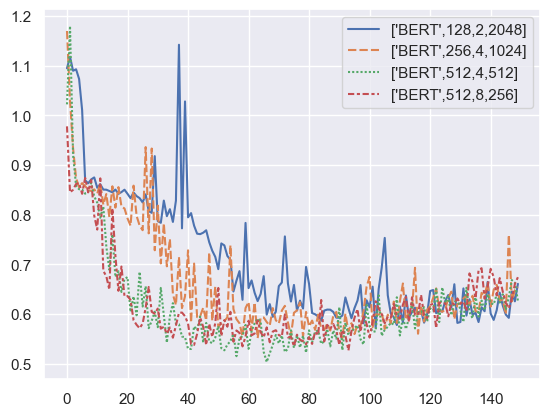

In [153]:
#Bert Loss Print
import seaborn as sns
bert_plot = pd.DataFrame(bert_loss).T
bert_plot.columns = bert_label
sns.set(style='darkgrid')
sns.lineplot(data=bert_plot)

<Axes: >

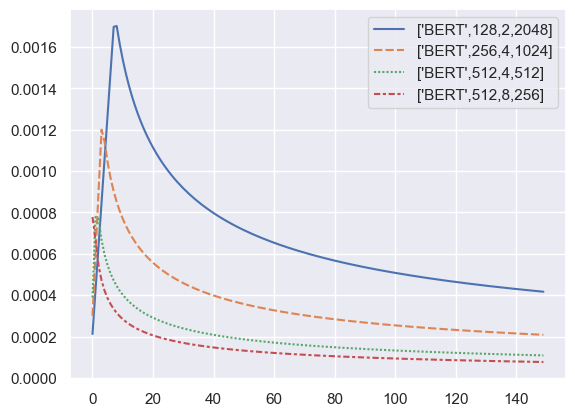

In [154]:
import seaborn as sns
bert_plot = pd.DataFrame(bert_lr).T
bert_plot.columns = bert_label
sns.set(style='darkgrid')
sns.lineplot(data=bert_plot)


#### Masked-Only GPT

<Axes: >

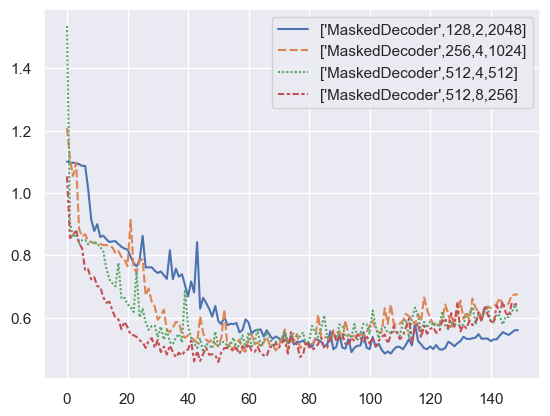

In [156]:
#Bert Loss Print
import seaborn as sns
masked_plot = pd.DataFrame(masked_loss).T
masked_plot.columns = masked_label
sns.set(style='darkgrid')
sns.lineplot(data=masked_plot)

<Axes: >

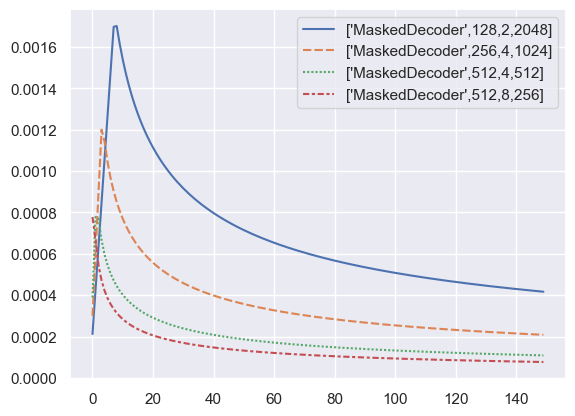

In [157]:
import seaborn as sns
masked_plot = pd.DataFrame(masked_lr).T
masked_plot.columns = masked_label
sns.set(style='darkgrid')
sns.lineplot(data=masked_plot)


#### GPT

<Axes: >

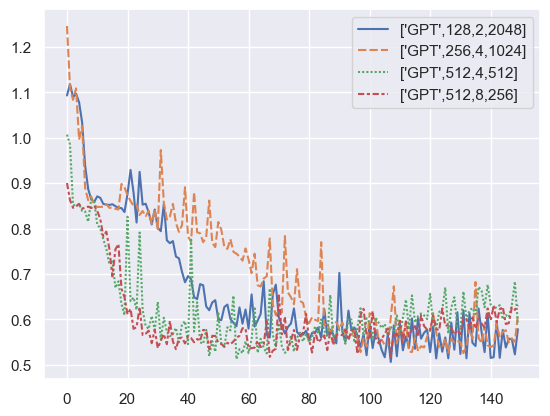

In [ ]:
import seaborn as sns
gpt_loss_plot = pd.DataFrame(gpt_loss).T
gpt_loss_plot.columns = gpt_label
sns.set(style='darkgrid')
sns.lineplot(data=gpt_loss_plot)


<Axes: >

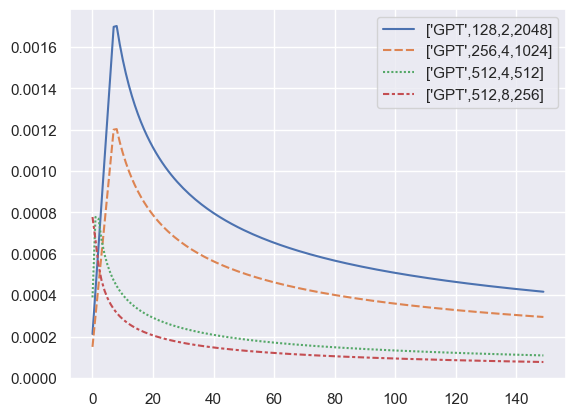

In [ ]:
import seaborn as sns
gpt_lr_plot = pd.DataFrame(gpt_lr).T
gpt_lr_plot.columns = gpt_label
sns.set(style='darkgrid')
sns.lineplot(data=gpt_lr_plot)


#### T5

<Axes: >

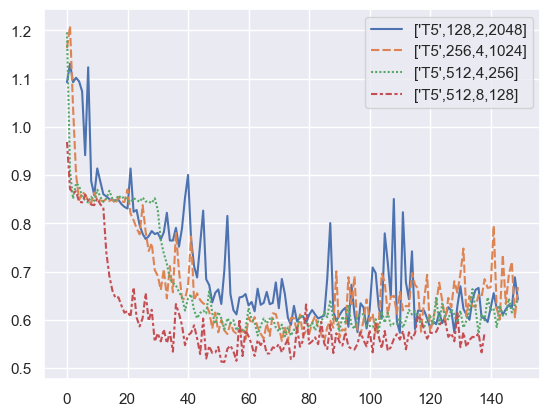

In [160]:
import seaborn as sns
t5_loss_plot = pd.DataFrame(t5_loss).T
t5_loss_plot.columns = t5_label
sns.set(style='darkgrid')
sns.lineplot(data=t5_loss_plot)


<Axes: >

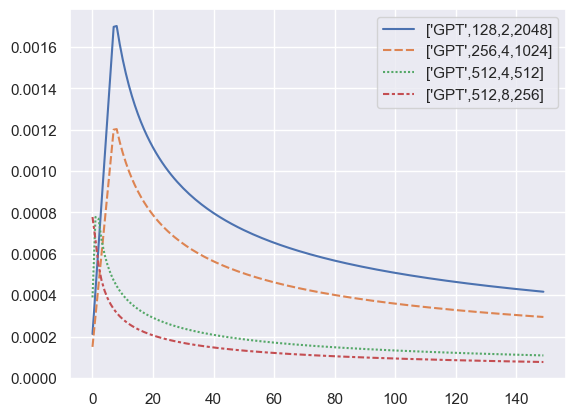

In [ ]:
import seaborn as sns
t5_lr_plot = pd.DataFrame(t5_lr).T
t5_lr_plot.columns = t5_label
sns.set(style='darkgrid')
sns.lineplot(data=t5_lr_plot)


### F1-Score Implementation

In [ ]:
params = [
            ['BERT',128,2,2048], # Tiny
            ['BERT',256,4,1024], # Mini
            ['BERT',512,4,512],  # Small
            ['BERT',512,8,256],  # Medium
            # ['BERT',768,12,32],  # Base
            # ['BERT',1024,24,32],  # Large
            ['MaskedDecoder',128,2,2048], # Tiny
            ['MaskedDecoder',256,4,1024], # Mini
            ['MaskedDecoder',512,4,512],  # Small
            ['MaskedDecoder',512,8,256],  # Medium
            # ['MaskedDecoder',768,12,32],  # Base
            # ['MaskedDecoder',1024,24,32],  # Large
            ['GPT',128,2,2048], # Tiny
            ['GPT',256,4,1024], # Mini
            ['GPT',512,4,512],  # Small
            ['GPT',512,8,256],  # Medium
            # # ['GPT',768,12,32],  # Base
            # # ['GPT',1024,24,32],  # Large
            ['T5',128,2,2048], # Tiny
            ['T5',256,4,1024], # Mini
            ['T5',512,4,256],  # Small
            ['T5',512,8,64],  # Medium
            # # ['T5',768,12,8],  # Base
            # ['T5',1024,24,32],  # Large
        ]
# Plot Learning rate curve, epoch loss,

model_dir = 'improved_lr'
dropout = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 150
num_heads = 8

general_f1 = []
general_acc = []

for param in params:
    model_name = f'{model_dir}/{param[0]}-{param[1]}_embs-{param[2]}_layers-{param[3]}_batches-transformer.pt'

    model_weights = torch.load(model_name,weights_only=False)

    vocab_size = model_weights['model_state_dict']['token_emb.weight'].size(0)
    target_size = 3
    d_model = model_weights['model_state_dict']['token_emb.weight'].size(1)
    # d_model = param[1]
    d_ff = d_model* 4
    num_layers = param[2]
    batch_size = param[3]

    if param[0] == 'BERT':
        model = BERT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)
    elif param[0] == 'MaskedDecoder':
        model = MaskedDecoder(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'GPT':
        model = GPT(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    elif param[0] == 'T5':
        model = T5(
            vocab_size=vocab_size,
            target_size=target_size,
            features_dim=d_model,
            num_heads=num_heads,
            ff_dim=d_ff,
            num_encoder_layers=num_layers,
            emb_dropout_prob=0.1,
            attn_dropout_prob=0.1,
            ff_dropout_prob=0.1,
            attn_use_bias=False,
            ff_use_bias=False,
            attn_res='pre',
            ff_res='pre',
            vocab_projection_bias=False,
        ).to(device)

    else:
        print('Error ')
        break

    print(param)
    class_weights = torch.tensor([1.2, 1.0, 1.0])
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.load_state_dict(model_weights['model_state_dict'])
    optimizer.state = model_weights['optimizer_state_dict']
    eval_loss = model_weights['eval_loss']

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()

    with torch.no_grad():
        with torch.autocast(device_type=device.type, dtype=torch.float16):
            src = torch.tensor(tokenized_datasets['test'][:]['input_ids']).to(device) # shape --> [batch size,seq len]
            trg = torch.tensor(tokenized_datasets['test'][:]['labels']).to(device) # shape --> [1, batch size]
            pad_mask = torch.tensor(tokenized_datasets['test'][:]['attention_mask']).to(device)
            #print('src: ',src.shape,'trg: ', trg.shape)
            # shape (out) --> [batch size, trg size]
            if param[0] == 'T5' or param[0] == 'GPT':
                cross_src = torch.tensor(tokenized_datasets['test'][:]['cluster_ids']).to(device) # shape --> [batch size,seq len]
                cross_pad_mask = torch.tensor(tokenized_datasets['test'][:]['cluster_mask']).to(device)
                out = model(src, cross_src, pad_mask, cross_pad_mask)
            else:
                out = model(src, pad_mask)

            loss = criterion(out, trg)

            _, predicted = torch.max(out, 1)
            total += trg.size(0)
            correct += (predicted == trg).sum().item()
            #print('trg', trg.tolist()[:4])
            #print('predicted', predicted.tolist()[:4])
            f1 = f1_score(trg.tolist(), predicted.tolist(), average='weighted')
            acc = 100 * correct // total
            print(f1)

        print('unique classes predicted by model:', predicted.unique().tolist())

    print(f'Accuracy of the network on the {total} test data: {acc} %')
    general_f1.append(f1)
    general_acc.append(acc)
np.save('general_acc.npy',np.array(general_acc))
np.save('general_f1.npy',np.array(general_f1))

['BERT', 128, 2, 2048]
0.8194697830438017
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 82 %
['BERT', 256, 4, 1024]
0.8433428288195687
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 84 %
['BERT', 512, 4, 512]
0.8505245349070069
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 85 %
['BERT', 512, 8, 256]
0.8467054491210255
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 84 %
['MaskedDecoder', 128, 2, 2048]
0.8494793856620411
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 85 %
['MaskedDecoder', 256, 4, 1024]
0.8568906363798648
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 85 %
['MaskedDecoder', 512, 4, 512]
0.8359480250361264
unique classes predicted by model: [0, 1, 2]
Accuracy of the network on the 5496 test data: 83 %
['M

##### Basic Version

In [41]:
bert_label = ["BERT,128,2,2048", # Tiny
    "BERT,256,4,1024", # Mini
    "BERT,512,4,512",  # Small
    "BERT,512,8,256"  # Medium
    ]
gpt_label = ["MaskedDecoder,128,2,2048", # Tiny
    "MaskedDecoder,256,4,1024", # Mini
    "MaskedDecoder,512,4,512",  # Small
    "MaskedDecoder,512,8,256"  # Medium
    ]
# Extend the Labels on another variable
all_label = bert_label + gpt_label

bert_acc = general_acc[:4]
gpt_acc = general_acc[4:]

bert_f1 = general_f1[:4]
gpt_f1 = general_f1[4:]

scoredf = pd.DataFrame([general_acc,general_f1],columns=all_label)
display(scoredf)

# Save the results as Numpy Array
np.save('general_acc.npy',np.array(general_acc))
np.save('general_f1.npy',np.array(general_f1))

,"BERT,128,2,2048","BERT,256,4,1024","BERT,512,4,512","BERT,512,8,256","MaskedDecoder,128,2,2048","MaskedDecoder,256,4,1024","MaskedDecoder,512,4,512","MaskedDecoder,512,8,256"
0,62.000000,74.00000,80.000000,83.000000,61.00000,74.000000,79.000000,82.000000
1,0.610284,0.73242,0.807215,0.834593,0.59891,0.743213,0.795099,0.821969


##### Optimized version

In [44]:
bert_label = ["BERT,128,2,2048", # Tiny
    "BERT,256,4,1024", # Mini
    "BERT,512,4,512",  # Small
    "BERT,512,8,256"  # Medium
    ]
gpt_label = ["MaskedDecoder,128,2,2048", # Tiny
    "MaskedDecoder,256,4,1024", # Mini
    "MaskedDecoder,512,4,512",  # Small
    "MaskedDecoder,512,8,256"  # Medium
    ]
# Extend the Labels on another variable
all_label = bert_label + gpt_label

bert_acc = general_acc[:4]
gpt_acc = general_acc[4:]

bert_f1 = general_f1[:4]
gpt_f1 = general_f1[4:]

scoredf = pd.DataFrame([general_acc,general_f1],columns=all_label)
display(scoredf)

# Save the results as Numpy Array
np.save('general_acc.npy',np.array(general_acc))
np.save('general_f1.npy',np.array(general_f1))

,"BERT,128,2,2048","BERT,256,4,1024","BERT,512,4,512","BERT,512,8,256","MaskedDecoder,128,2,2048","MaskedDecoder,256,4,1024","MaskedDecoder,512,4,512","MaskedDecoder,512,8,256"
0,67.000000,86.000000,83.000000,84.0000,63.000000,82.000000,84.000000,84.000000
1,0.653383,0.861022,0.831822,0.8468,0.612122,0.829319,0.842397,0.843559


In [ ]:
old_general_acc = np.load('old_models/general_acc.npy')
old_general_f1 = np.load('old_models/general_f1.npy')

imp_general_acc = np.load('improved_model/general_acc.npy')
imp_general_f1 = np.load('improved_model/general_f1.npy')

imp_lr_general_acc = np.load('improved_lr/general_acc.npy')
imp_lr_general_f1 = np.load('improved_lr/general_f1.npy')

In [6]:
# model, emb, layer, batch
params_label = [
            "['BERT',128,2,2048]", # Tiny
            "['BERT',256,4,1024]", # Mini
            "['BERT',512,4,512]",  # Small
            "['BERT',512,8,256]",  # Medium
            # ['BERT',768,12,32],  # Base
            # ['BERT',1024,24,32],  # Large
            "['MaskedDecoder',128,2,2048]", # Tiny
            "['MaskedDecoder',256,4,1024]", # Mini
            "['MaskedDecoder',512,4,512]",  # Small
            "['MaskedDecoder',512,8,256]",  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            "['GPT',128,2,2048]", # Tiny
            "['GPT',256,4,1024]", # Mini
            "['GPT',512,4,512]",  # Small
            "['GPT',512,8,256]",  # Medium
            # ['GPT',768,12,32],  # Base
            # ['GPT',1024,24,32],  # Large
            "['T5',128,2,2048]", # Tiny
            "['T5',256,4,1024]", # Mini
            "['T5',512,4,256]",  # Small
            "['T5',512,8,128]",  # Medium
            # ['T5',768,12,8],  # Base
            # ['T5',1024,24,32],  # Large
        ]


bert_label = params_label[:4]
old_bert_acc = old_general_acc[:4]
old_bert_f1 = old_general_f1[:4]

masked_label = params_label[4:8]
old_masked_acc = old_general_acc[4:8]
old_masked_f1 = old_general_f1[4:8]

imp_bert_acc = imp_general_acc[:4]
imp_bert_f1 = imp_general_f1[:4]

imp_masked_acc = imp_general_acc[4:8]
imp_masked_f1 = imp_general_f1[4:8]

imp_lr_bert_acc = imp_lr_general_acc[:4]
imp_lr_bert_f1 = imp_lr_general_f1[:4]

imp_lr_masked_acc = imp_lr_general_acc[4:8]
imp_lr_masked_f1 = imp_lr_general_f1[4:8]

#### Accuracy Check

In [12]:
scoredf = pd.DataFrame([old_general_acc,imp_general_acc,imp_lr_general_acc[:8]],columns=bert_label+masked_label)
display(scoredf)

,"['BERT',128,2,2048]","['BERT',256,4,1024]","['BERT',512,4,512]","['BERT',512,8,256]","['MaskedDecoder',128,2,2048]","['MaskedDecoder',256,4,1024]","['MaskedDecoder',512,4,512]","['MaskedDecoder',512,8,256]"
0,62,74,80,83,61,74,79,82
1,67,86,83,84,63,82,84,84
2,82,84,85,84,85,85,83,84


#### F1-Score Check

In [13]:
scoredf = pd.DataFrame([old_general_f1,imp_general_f1,imp_lr_general_f1[:8]],columns=bert_label+masked_label)
display(scoredf)

,"['BERT',128,2,2048]","['BERT',256,4,1024]","['BERT',512,4,512]","['BERT',512,8,256]","['MaskedDecoder',128,2,2048]","['MaskedDecoder',256,4,1024]","['MaskedDecoder',512,4,512]","['MaskedDecoder',512,8,256]"
0,0.610284,0.732420,0.807215,0.834593,0.598910,0.743213,0.795099,0.821969
1,0.653383,0.861022,0.831822,0.846800,0.612122,0.829319,0.842397,0.843559
2,0.819470,0.843343,0.850525,0.846705,0.849479,0.856891,0.835948,0.841900


##### Optimized version with Noam Optimization

In [167]:
bert_label = params_label[:4]
bert_acc = general_acc[:4]
bert_lr = general_f1[:4]

masked_label = params_label[4:8]
masked_acc = general_acc[4:8]
masked_f1 = general_f1[4:8]

gpt_label = params_label[8:12]
gpt_acc = general_acc[8:12]
gpt_f1 = general_f1[8:12]

t5_label = params_label[12:]
t5_acc = general_acc[12:]
t5_f1 = general_f1[12:]

all_label = bert_label + masked_label + gpt_label + t5_label

scoredf = pd.DataFrame([general_acc,general_f1],columns=all_label)
display(scoredf)

# Save the results as Numpy Array
np.array(general_acc).tofile('all_general_acc.data')
np.array(general_f1).tofile('all_general_f1.data')

,"['BERT',128,2,2048]","['BERT',256,4,1024]","['BERT',512,4,512]","['BERT',512,8,256]","['MaskedDecoder',128,2,2048]","['MaskedDecoder',256,4,1024]","['MaskedDecoder',512,4,512]","['MaskedDecoder',512,8,256]","['GPT',128,2,2048]","['GPT',256,4,1024]","['GPT',512,4,512]","['GPT',512,8,256]","['T5',128,2,2048]","['T5',256,4,1024]","['T5',512,4,256]","['T5',512,8,128]"
0,82.00000,84.000000,85.000000,84.000000,85.000000,85.000000,83.000000,84.0000,83.000000,82.000000,82.000000,83.000000,82.000000,83.00000,81.000000,81.000000
1,0.81947,0.843343,0.850525,0.846705,0.849479,0.856891,0.835948,0.8419,0.835295,0.823977,0.825153,0.838685,0.826689,0.83174,0.809202,0.815305


In [ ]:
report = classification_report(trg.tolist(), predicted.tolist(), target_names=['neg','neu','pos'])
print(report)

cm=confusion_matrix(trg.tolist(), predicted.tolist())
print(cm)

              precision    recall  f1-score   support

         neg       0.81      0.68      0.74      1556
         neu       0.79      0.80      0.80      2224
         pos       0.78      0.87      0.82      1717

    accuracy                           0.79      5497
   macro avg       0.79      0.78      0.78      5497
weighted avg       0.79      0.79      0.79      5497

[[1055  332  169]
 [ 175 1789  260]
 [  71  153 1493]]
